## Import libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import model_from_json

import pandas as pd
import numpy as np
from PIL import Image

from matplotlib import pyplot as plt
from mpl_toolkits import axes_grid1
from sklearn.metrics.pairwise import pairwise_distances

import keras
from keras.layers import GlobalMaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input


## Define functions

In [11]:
def get_model():
    # Model reconstruction from JSON file
    with open('models/autoencoder_512_new.json', 'r') as f:
        encoder = model_from_json(f.read())

    # Load weights into the new model
    encoder.load_weights("models/autoencoder_512_new.hdf5")
    encoder.compile(optimizer="adam", loss="mse")
    encoder = tf.keras.models.Model(inputs=encoder.input, outputs=encoder.get_layer('encoder').output)

    # Add Layer Embedding
    model = keras.Sequential([
        encoder,
        GlobalMaxPooling2D() ## change to AVGpooling
    ])

    # base_model = ResNet50(weights ='imagenet', include_top = False, input_shape = (224,224,3))
    # base_model.trainable = False

    # model = keras.Sequential([base_model, GlobalMaxPooling2D()])
    return model

def load_image(img_path):
    img = Image.open(img_path).convert('RGB') ## RGB for 3 channels, L for grayscale
    size = 224, 224
    img = img.resize(size, Image.Resampling.LANCZOS)
    img = np.asarray(img)
    img = img.astype('float32')/255.
    # img = img.astype('float32')

    # img = preprocess_input(img)
    return img

def get_embedding(model, img_path):
    try:
        img = load_image(img_path)
        x  = np.expand_dims(img, axis=0)
        print(type(x))
        print(x.shape)
    except:
        print("Image corrupted or not compatible")
        return
    return model.predict(x).reshape(-1)

def get_cosine_matrix(embedded_df):
    # Calcule Distance Matrix
    cosine_sim = 1-pairwise_distances(embedded_df, metric='cosine')
    print(cosine_sim.shape)    
    return cosine_sim

def get_recommender(cosine_sim, top_n = 5):
    # sim_idx = indices[idx]
    sim_scores = list(enumerate(cosine_sim[-1]))
    print("Sim scores: ", len(sim_scores))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # sim_scores = sim_scores[1:top_n+1]
    sim_scores = sim_scores[1:top_n+1]
    idx_rec = [i[0] for i in sim_scores]
    idx_sim = [i[1] for i in sim_scores]
    
    # return indices.iloc[idx_rec].index, idx_sim
    return idx_rec, idx_sim, sim_scores

def get_embedded_data():
    ## Load the embedded dataset
    embedded_df = pd.read_csv('utils/embedded_data_512_new.csv',dtype=object)
    return embedded_df

def get_dataset():
    ## Load the original available dataset
    
    ## labels to remove
    removeLabels = ['1','2','6','10','16','18','25']

    train_samples = pd.read_csv('utils/style_train.csv',dtype=object, header=None, names = ['imagePath', 'label'])
    # train_samples['imagePath'] = 'wikiart/' + train_samples['imagePath'].astype(str)
    train_samples = train_samples.loc[~train_samples["label"].isin(removeLabels)]
    train_samples = train_samples[:10000]
    
    print(train_samples.shape)
    # train_samples = pd.read_csv('utils/path_data.csv',dtype=object, header=None, names = ['imagePath', 'label'])
    # train_samples['imagePath'] = 'wikiart/' + train_samples['imagePath'].astype(str)
    # train_samples = train_samples[:10000]
    # print(train_samples.shape)
    train_samples = train_samples.reset_index(drop=True)
    return train_samples

### Execute new input

In [32]:
model = get_model()
# print("model.input_shape: ", model.input_shape)
train_samples = get_dataset()

img_path = "examples/seoul_5.jpg"
new_input = get_embedding(model, img_path)

print(type(new_input))
print(new_input.shape)

embedded_df = get_embedded_data()
print(embedded_df.shape)
embedded_df = embedded_df.append(pd.DataFrame(new_input.reshape(1,-1), columns=list(embedded_df)), ignore_index=True)
print(embedded_df.shape)
cosine_sim = get_cosine_matrix(embedded_df)
print(cosine_sim.shape)
# cosine_sim

(10000, 2)
<class 'numpy.ndarray'>
(1, 224, 224, 3)
1/1 [==============================] - 0s 58ms/step
<class 'numpy.ndarray'>
(512,)
(10000, 512)
(10001, 512)


C:\Users\Abdi\AppData\Local\Temp\ipykernel_9896\1879770192.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedded_df = embedded_df.append(pd.DataFrame(new_input.reshape(1,-1), columns=list(embedded_df)), ignore_index=True)


(10001, 10001)
(10001, 10001)


Sim scores:  10001
[2200, 6801, 9869, 6121, 418, 6217]
[0.9556623564111325, 0.9540825797070727, 0.9528364657352496, 0.9527198516481072, 0.9519748759085818, 0.9507701482370094]
6
[(2200, 0.9556623564111325), (6801, 0.9540825797070727), (9869, 0.9528364657352496), (6121, 0.9527198516481072), (418, 0.9519748759085818), (6217, 0.9507701482370094)]
Image:  examples/seoul_5.jpg


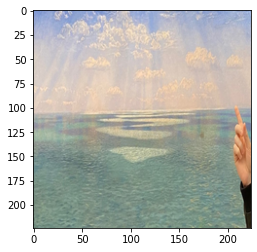

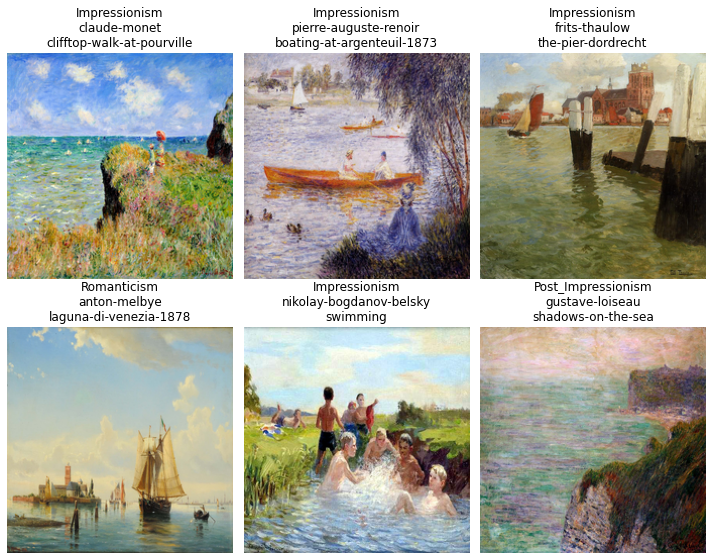

In [33]:
# import matplotlib
# Idx Item to Recommender
# idx_ref = len(embedded_df)

### Post_Impressionism/vincent-van-gogh_the-starry-night-1888-1.jpg,22


# Recommendations
# idx_rec, idx_sim = get_recommender(idx_ref, 0, top_n = 6)
idx_rec, idx_sim, sim_scores = get_recommender(cosine_sim, top_n = 6)
print(idx_rec)
print(idx_sim)
print(len(sim_scores))
print(sim_scores)

# def plot_figures(figures, nrows = 1, ncols=1, figsize=(8, 8)):
#     fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
#     for ind,title in enumerate(figures):
#         axeslist.ravel()[ind].imshow(figures[title])
#         axeslist.ravel()[ind].set_title(title)
#         axeslist.ravel()[ind].set_axis_off()
#     plt.tight_layout() # optional

def plot_figures(figuresDic, nrows = 1, ncols=1, figsize=(10, 8)):
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figuresDic):
        axeslist.ravel()[ind].imshow(figuresDic[title][0])
        axeslist.ravel()[ind].set_title(figuresDic[title][1] + '\n' + figuresDic[title][2] + '\n' + figuresDic[title][3])       
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    


def load_image2(img_path):
    img = Image.open(img_path).convert('RGB') ## RGB for 3 channels, L for grayscale
    size = 224, 224
    img = img.resize(size, Image.Resampling.LANCZOS)
    img = np.asarray(img)
    img = img.astype('float32')/255.
    # img = img.astype('float32')
    # img = preprocess_input(img)
    return img

# Plot
# print("Index: ", idx_ref)
print("Image: ", img_path)
plt.imshow(load_image2(img_path))
plt.show()

# generation of a dictionary of (title, images)
# figures = {'image'+str(i): load_image(row.imagePath) for i, row in train_samples.loc[idx_rec].iterrows()}
# print(type(figures))
# print(len(figures))
# # print(figures)
# plot_figures(figures, 2, 3)

figuresDic = {}
for i, row in train_samples.loc[idx_rec].iterrows():
    infoTemp = row.imagePath.split("/")
    style = infoTemp[-2]
    nameTemp = infoTemp[-1].split("_")
    artist = nameTemp[0]
    artName = nameTemp[1].replace(".jpg", "")
    figuresDic[artName] = [load_image2(row.imagePath), style, artist, artName]

plot_figures(figuresDic, 2, 3)
# for ind,title in enumerate(figuresDic):
#     print("ind: ", ind)
#     # print("title: ", title)
#     print(figuresDic[title][1]) ## Style
#     print(figuresDic[title][2]) ## Artist
#     print(figuresDic[title][3]) ## ArtName
#     plt.imshow(figuresDic[title][0]) ## Image
#     plt.show()
    

